# Setup, Constants, and Imports

In [1]:
import os
import sys
import logging

## Notebook Configs

In [2]:
IS_COLAB = 'google.colab' in sys.modules
OUTPUT_PROCESSED_FILES = False # TODO: Use this if you want to output save files (optional - see below)

if IS_COLAB:
    from google.colab import userdata
    GITHUB_USERNAME = userdata.get('github_user')
    GITHUB_TOKEN = userdata.get('github_token')
    GITHUB_EMAIL = userdata.get('github_email')

## Constants

In [3]:
REPO_URL = "https://github.com/EErlando/Quarterly-Bytes.git"
REPO_NAME = "src"
REPO_BRANCH = "LP_topic_modelling_extended" # TODO: UPDATE THIS TO YOU BRANCH - DEFAULT TO MAIN
NOTEBOOK_DIR = "3_modelling" # TODO: UPDATE THIS TO YOUR NOTEBOOK DIRECTORY (e.g. 1_data_extraction_and_processing)

## Clone and Pull Latest from Repository - Colab Specific

In [4]:
if IS_COLAB:
    !git config pull.rebase false
    if os.path.exists(REPO_NAME):
        print(f"Directory '{REPO_NAME}' already exists. Pulling latest changes...")
        %cd {REPO_NAME}
        !git pull origin {REPO_BRANCH} --quiet
        %cd ..
    else:
        print(f"Cloning repository into '{REPO_NAME}'...")
        !git clone --quiet --branch {REPO_BRANCH} {REPO_URL} {REPO_NAME}
        print("Clone complete.")

    sys.path.append('/content/src/')
    %cd /content/src/
    !pip install -r requirements.txt
else:
    if os.path.basename(os.getcwd()) == NOTEBOOK_DIR:
        os.chdir('../../') # TODO: UPDATE THIS TO ROOT OF REPO

    !pip install -r requirements.txt

logging.basicConfig(level=logging.ERROR, format='%(levelname)s: %(message)s')

fatal: not in a git directory
Directory 'src' already exists. Pulling latest changes...
/content/src
fatal: '{AUTHENTICATED_REPO_URL}' does not appear to be a git repository
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
/content
/content/src


## Post Install Imports

In [5]:
import pandas as pd
import numpy as np
import pandas as pd
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import os
!pip install bertopic

from bertopic import BERTopic


In [6]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Local Imports

In [7]:
from src.utils.common_helpers import read_yaml_file, read_list_from_text_file

## Helpers

In [8]:
def group_df(df, group_by_columns, agg_column='content'):
    """
    Groups the DataFrame by specified columns and aggregates the content column.

    Parameters:
    - df: DataFrame to group
    - group_by_columns: List of columns to group by
    - agg_column: Column to aggregate (default is 'content')

    Returns:
    - Grouped DataFrame with aggregated content
    """
    return df.groupby(group_by_columns, as_index=False).agg({agg_column: ' '.join})


## Load Data

In [9]:
gs_discussion_df = pd.read_csv('data/processed/Goldman Sachs/discussion_df.csv')
gs_qna_df = pd.read_csv('data/processed/Goldman Sachs/qna_df.csv')
jp_discussion_df = pd.read_csv('data/processed/JP Morgan/discussion_df.csv')
jp_qna_df = pd.read_csv('data/processed/JP Morgan/qna_df.csv')


# Goldman Sachs
# grouped_gs_discussion_df = group_df(gs_discussion_df, ['quarter', 'year'])
grouped_gs_qna_df = group_df(gs_qna_df, ['question_answer_group_id', 'quarter', 'year'])

# JP Morgan
# grouped_jp_discussion_df = group_df(jp_discussion_df, ['quarter', 'year'])
grouped_jp_qna_df = group_df(jp_qna_df, ['question_answer_group_id', 'quarter', 'year'])


In [10]:
import pandas as pd
import spacy

# Global variable to store the spaCy model, to prevent re-loading multiple times
_nlp_model = None

def get_spacy_model():
    """
    Loads and returns the spaCy 'en_core_web_sm' model.
    Downloads it if not already present.
    """
    global _nlp_model
    if _nlp_model is None:
        try:
            # Try loading without parser and NER for speed if only sentencizer is needed
            _nlp_model = spacy.load("en_core_web_sm", disable=["parser", "ner"])
            _nlp_model.add_pipe('sentencizer')
        except OSError:
            print("Downloading spaCy model 'en_core_web_sm'...")
            # This command is for direct execution in environments like Colab
            # In a standard Python script, you might run this once before your script
            import subprocess
            subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
            _nlp_model = spacy.load("en_core_web_sm", disable=["parser", "ner"])
            _nlp_model.add_pipe('sentencizer')
    return _nlp_model

def split_text_into_sentence_chunks(
    df: pd.DataFrame,
    text_column: str,
    sentences_per_chunk: int = 2,
    new_column_name: str = 'content_chunked'
) -> pd.DataFrame:
    """
    Splits the content of a specified text column in a DataFrame into
    chunks of a given number of sentences, and returns a new DataFrame
    with rows exploded by these chunks.

    Parameters:
    - df: The input Pandas DataFrame.
    - text_column: The name of the column in the DataFrame containing the text to be split.
    - sentences_per_chunk: The approximate number of sentences per chunk. Defaults to 2.
    - new_column_name: The name for the new column containing the text chunks.
                       Defaults to 'content_chunked'.

    Returns:
    - A new DataFrame with text content split into chunks and exploded into new rows.
    """
    df_copy = df.copy() # Work on a copy to avoid modifying the original DataFrame

    # Ensure spaCy model is loaded
    nlp_model_instance = get_spacy_model()

    def _split_content_into_sentences_internal(text):
        """
        Internal helper to split a single text into chunks of sentences.
        """
        if not isinstance(text, str):
            return [] # Return empty list for non-string input

        doc = nlp_model_instance(text)
        sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()] # Filter empty sentences

        chunks = []
        current_chunk = []
        for i, sentence in enumerate(sentences):
            current_chunk.append(sentence)
            # Create a chunk if we've reached the desired number of sentences
            # or if it's the last sentence(s) of the text
            if (i + 1) % sentences_per_chunk == 0 or i == len(sentences) - 1:
                if current_chunk: # Only add if the chunk is not empty
                    chunks.append(" ".join(current_chunk))
                current_chunk = [] # Reset for the next chunk
        return chunks
    df_copy[new_column_name] = df_copy[text_column].apply(_split_content_into_sentences_internal)
    exploded_df = df_copy.explode(new_column_name)
    exploded_df = exploded_df.drop(columns=[text_column])
    exploded_df = exploded_df.rename(columns={new_column_name: text_column})

    return exploded_df

processed_gs_discussion_df = split_text_into_sentence_chunks(
    gs_discussion_df,
    text_column='content',
    sentences_per_chunk=4
)

processed_jp_discussion_df = split_text_into_sentence_chunks(
    jp_discussion_df,
    text_column='content',
    sentences_per_chunk=4
)

In [11]:
processed_jp_discussion_df.head(2)

,speaker,role,company,year,quarter,content
0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,2022,1,"Thanks, operator. Good morning, everyone. The ..."
0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,2022,1,These results include approximately $900 milli...


# Topic Modelling

In [12]:
gs_stopwords = set(read_list_from_text_file('src/data_processing/goldman_sachs_topic_modelling_stopwords.txt'))
jp_stopwords = set(read_list_from_text_file('src/data_processing/jp_morgan_topic_modelling_stopwords.txt'))
abbreviations = read_yaml_file('src/abbreviations.yaml')

https://arxiv.org/pdf/2504.15683
Use FinTextSim

In [13]:


try:
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
except OSError:
    print("SpaCy 'en_core_web_sm' model not found. Please run: python -m spacy download en_core_web_sm")
    exit()

gs_stopwords = nlp.Defaults.stop_words.union(gs_stopwords)
jp_stopwords = nlp.Defaults.stop_words.union(jp_stopwords)


In [14]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
import os
from bertopic import BERTopic
from umap import UMAP
import hdbscan
from sentence_transformers import SentenceTransformer

def preprocess_text(text: str, stop_words: set, abbreviations: dict) -> str:
    if not isinstance(text, str):
        return ""

    processed_text = text.lower()
    processed_text = re.sub(r'[-_]+', ' ', processed_text).strip()

    sorted_phrases = sorted(abbreviations.items(), key=lambda item: len(item[1]), reverse=True)

    for abbrev, phrase in sorted_phrases:
        processed_text = re.sub(r'\b' + re.escape(phrase.lower()) + r'\b', abbrev.lower(), processed_text)

    processed_text = re.sub(r'\b\d+\b', '', processed_text).strip()

    doc = nlp(processed_text)

    tokens = []
    for token in doc:
        if token.text not in stop_words or token.text in abbreviations.keys():
            tokens.append(token.lemma_) # Lemmatize the token (abbreviations won't change)

    return " ".join(tokens)

# --- Custom Transformer for Text Preprocessing ---
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    A custom scikit-learn transformer to apply text preprocessing.
    It wraps the 'preprocess_text' function.
    """
    def __init__(self, stop_words=None, abbreviations=None):
        self.stop_words = stop_words
        self.abbreviations = abbreviations

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print("Starting Phase 1: Preprocessing...")
        preprocessed_X = [preprocess_text(text, self.stop_words, self.abbreviations) for text in X]
        print("Preprocessing complete.")
        return pd.Series(preprocessed_X)


# --- Custom Estimator for BERTopic Modeling ---
class BERTopicWrapper(BaseEstimator, TransformerMixin):
    """
    A custom scikit-learn estimator that wraps BERTopic.
    """
    def __init__(self, embedding_model='all-MiniLM-L6-v2', umap_args=None, hdbscan_args=None,
                 vectorizer_args=None, nr_topics="auto", calculate_probabilities=True, **bertopic_kwargs):

        self.embedding_model_name = embedding_model
        self.umap_args = umap_args if umap_args is not None else {}
        self.hdbscan_args = hdbscan_args if hdbscan_args is not None else {}
        self.vectorizer_args = vectorizer_args if vectorizer_args is not None else {}
        self.nr_topics = nr_topics
        self.calculate_probabilities = calculate_probabilities
        self.bertopic_kwargs = bertopic_kwargs
        self.bertopic_model = None

    def fit(self, X, y=None):
        print("\nStarting Phase 3: Topic Modeling (BERTopic)...")

        # Initialize UMAP and HDBSCAN models
        umap_model = UMAP(**self.umap_args)
        hdbscan_model = hdbscan.HDBSCAN(
            # metric='euclidean',
            # cluster_selection_method='eom',
            # prediction_data=True, # Required for transform to assign topics to new data
            **self.hdbscan_args
        )

        # Initialize SentenceTransformer
        embedding_model = SentenceTransformer(self.embedding_model_name)

        default_min_df_for_bertopic_vectorizer = 1 # Changed from 10 to 1 for higher permissiveness

        # Combine default vectorizer args with user-provided args
        combined_vectorizer_args = {
            'min_df': default_min_df_for_bertopic_vectorizer,
            'ngram_range': (1, 3), # Common default for BERTopic's internal vectorizer
            **self.vectorizer_args # User-provided vectorizer_args will override these defaults
        }

        vectorizer_model = TfidfVectorizer(**combined_vectorizer_args)


        self.bertopic_model = BERTopic(
            embedding_model=embedding_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            nr_topics=self.nr_topics,
            calculate_probabilities=self.calculate_probabilities,
            **self.bertopic_kwargs
        )

        # X is expected to be a pandas Series of preprocessed text
        self.topics, self.probs = self.bertopic_model.fit_transform(X.tolist())
        print("BERTopic model fitting complete.")
        return self

    def transform(self, X):
        if self.bertopic_model is None:
            raise RuntimeError("BERTopic model not fitted. Call fit() first.")
        print("Transforming data with fitted BERTopic model...")
        topics, probs = self.bertopic_model.transform(X.tolist())
        print("Transformation complete.")
        return topics # Return topic assignments

    def get_model(self):
        return self.bertopic_model

# --- Utility function to display topics (adapted for both LDA and BERTopic) ---
def display_topics(model, vectorizer=None, no_top_words=10, file=None):
    """
    Prints or writes the top words for each topic.
    Args:
        model: The fitted topic model (LDA or BERTopic).
        vectorizer (TfidfVectorizer, optional): The fitted TF-IDF vectorizer (for LDA).
        no_top_words (int): The number of top words to display for each topic.
        file (file object, optional): If provided, topics will be written to this file.
        model_type (str): 'lda' or 'bertopic' to specify model type for appropriate display.
    """
    topic_info = model.get_topic_info()
    output_str = "\nBERTopic - Top Words per Topic:\n"
    if file:
        file.write(output_str)
    else:
        print(output_str)

    # Iterate through all topics, excluding the noise topic (-1)
    for topic_id in topic_info.Topic.unique():
        if topic_id == -1: # Skip noise topic
            continue
        # Get the top words for the current topic
        words = model.get_topic(topic_id)
        if words:
            top_words = ", ".join([word for word, _ in words[:no_top_words]])
            topic_name = topic_info[topic_info['Topic'] == topic_id]['Name'].iloc[0]
            output_str = f"Topic {topic_id} ({topic_name}): {top_words}\n"
            if file:
                file.write(output_str)
            else:
                print(output_str)
        else:
            output_str = f"Topic {topic_id}: No words found.\n"
            if file:
                file.write(output_str)
            else:
                print(output_str)


# --- Main Topic Modeling Pipeline Class ---
class TopicModelingPipeline:
    def __init__(self, model_type='lda', **kwargs):
        """
        Initializes the topic modeling pipeline.

        Args:
            model_type (str): The type of topic model to use ('lda' or 'bertopic').
            **kwargs: Arguments specific to the chosen model or pipeline steps.
                      For LDA: max_df, min_df, ngram_range (for TF-IDF), n_components, max_iter, etc.
                      For BERTopic: embedding_model, umap_args, hdbscan_args, vectorizer_args, nr_topics, etc.
        """
        self.model_type = model_type
        self.pipeline = self._build_pipeline(**kwargs)

    def _build_pipeline(self, **kwargs):
        """Builds the scikit-learn pipeline based on the specified model_type."""
        preprocessor_kwargs = {
            'stop_words': kwargs.pop('stop_words', []),
            'abbreviations': kwargs.pop('abbreviations', {})
        }

        pipeline_steps = [
            ('preprocessor', TextPreprocessor(**preprocessor_kwargs))
        ]

        bertopic_kwargs = {
            'embedding_model': kwargs.pop('embedding_model', 'all-MiniLM-L6-v2'),
            'umap_args': kwargs.pop('umap_args', {}),
            'hdbscan_args': kwargs.pop('hdbscan_args', {}),
            'vectorizer_args': kwargs.pop('vectorizer_args', {}), # Pass custom vectorizer_args here
            'nr_topics': kwargs.pop('nr_topics', "auto"),
            'calculate_probabilities': kwargs.pop('calculate_probabilities', True),
            **kwargs # Pass any remaining kwargs directly to BERTopicWrapper
        }
        pipeline_steps.append(('topic_modeler', BERTopicWrapper(**bertopic_kwargs)))

        # Any remaining kwargs are ignored if not consumed by model-specific initializations
        if kwargs:
            print(f"Warning: Unused keyword arguments passed to pipeline: {kwargs}")

        return Pipeline(pipeline_steps)

    def fit(self, X, y=None):
        """Fits the entire pipeline to the input data."""
        print(f"\n--- Fitting {self.model_type.upper()} Topic Modeling Pipeline ---")
        self.pipeline.fit(X, y)
        return self

    def transform(self, X):
        """Transforms the input data and returns topic assignments/distributions."""
        return self.pipeline.transform(X)

    def get_topic_model(self):
        """Returns the underlying fitted topic model (LDA or BERTopic)."""
        return self.pipeline.named_steps['topic_modeler'].get_model()

    def get_vectorizer(self):
        """Returns the fitted vectorizer (TF-IDF for LDA, None for BERTopic)."""
        if self.model_type == 'lda':
            return self.pipeline.named_steps['tfidf_vectorizer']
        return None


## Goldman Sachs

### Management Discussion

In [15]:

# import itertools
# output_dir = "data/temp/leslie_topic_modelling_fine_tuning/bert/gs/management_discussions/"
# os.makedirs(output_dir, exist_ok=True)

# AUTHENTICATED_REPO_URL = REPO_URL.replace("https://", f"https://{GITHUB_USERNAME}:{GITHUB_TOKEN}@")
# no_top_words = 10

# target_stopwords = gs_stopwords
# target_df = processed_gs_discussion_df

# # Define parameter grids for grid-like search
# param_grid = {
#     'umap_n_neighbors': [15, 30], # Common values: 5-50
#     'umap_n_components': [5, 10], # Common values: 2-15
#     'hdbscan_min_cluster_size': [5, 10], # Common values: 5-50+ depending on dataset size
#     'vectorizer_min_df': [1, 5], # Common values: 1-10 or 0.01-0.05 (percentage)
#     'vectorizer_ngram_range': [(1, 1), (1, 2)] # (1,1) for unigrams, (1,2) for unigrams and bigrams
# }

# # Generate all combinations of parameters
# keys = param_grid.keys()
# combinations = itertools.product(*(param_grid[key] for key in keys))

# results = []

# for i, combo in enumerate(combinations):
#     params = dict(zip(keys, combo))

#     # Construct filename
#     filename_parts = []
#     for k, v in params.items():
#         if isinstance(v, tuple): # Handle tuples like ngram_range
#             filename_parts.append(f"{k}_{'_'.join(map(str, v))}")
#         else:
#             filename_parts.append(f"{k}_{v}")

#     output_filename_base = "_".join(filename_parts)
#     output_filename_bertopic = f"{output_dir}/bertopic_topics_{output_filename_base}.txt"
#     model_save_path = f"{output_dir}/bertopic_model_{output_filename_base}.joblib"

#     print(f"\n--- Running experiment {i+1} with parameters: {params} ---")

#     try:
#         # Initialize pipeline with current parameters
#         bertopic_pipeline_instance = TopicModelingPipeline(
#             embedding_model='all-MiniLM-L6-v2', # Keep embedding model constant for this grid search
#             model_type='bertopic',
#             nr_topics="auto", # Let HDBSCAN determine topics first, then prune if needed
#             calculate_probabilities=False, # Set to False for faster runs if probabilities aren't immediately needed for tuning
#             umap_args={'n_neighbors': params['umap_n_neighbors'], 'n_components': params['umap_n_components'], 'random_state': 42},
#             hdbscan_args={'min_cluster_size': params['hdbscan_min_cluster_size'], 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True},
#             vectorizer_args={'min_df': params['vectorizer_min_df'], 'ngram_range': params['vectorizer_ngram_range']},
#             stop_words=target_stopwords,
#             abbreviations=abbreviations
#         )

#         bertopic_pipeline_instance.fit(target_df['content'])
#         bertopic_model = bertopic_pipeline_instance.get_topic_model()

#         # Save topic info to file
#         with open(output_filename_bertopic, 'w', encoding='utf-8') as f:
#             f.write(f"--- BERTopic Model - Parameters: {params} ---\n\n")
#             f.write("Interpreting Topics:\n")
#             display_topics(bertopic_model, no_top_words=no_top_words, file=f)
#         print(f"BERTopic Topics saved to {output_filename_bertopic}")

#         !git config user.email "{GITHUB_EMAIL}"
#         !git config user.name "{GITHUB_USERNAME}"
#         !git remote set-url origin {AUTHENTICATED_REPO_URL}

#         # Add the file to staging
#         !git add {output_filename_bertopic}
#         print(f"Added '{output_filename_bertopic}' to staging.")

#         # Commit the changes
#         commit_message = f"Add new data file: {output_filename_bertopic}"
#         !git commit -m "{commit_message}"
#         print(f"Committed changes with message: '{commit_message}'")
#         print(f"Attempted commit with message: '{commit_message}'")

#         # Add this line to debug:
#         print(f"Value of REPO_BRANCH before push: {REPO_BRANCH}")

#         print("Pushing changes to GitHub. Please enter your GitHub username and Personal Access Token when prompted.")
#         !git push --set-upstream origin {REPO_BRANCH} --force

#         results.append({
#             'params': params,
#             'output_file': output_filename_bertopic,
#             'num_topics': len(bertopic_model.get_topic_info()) - 1 # Exclude -1 topic
#             # Add more metrics here if you implement them (e.g., coherence scores)
#         })

#     except Exception as e:
#         print(f"Error running experiment with parameters {params}: {e}")
#         results.append({'params': params, 'error': str(e)})

# print("\n--- Grid Search Complete ---")
# print("Summary of Runs:")
# for res in results:
#     if 'error' in res:
#         print(f"  Parameters: {res['params']} -> ERROR: {res['error']}")
#     else:
#         print(f"  Parameters: {res['params']} -> Topics: {res['num_topics']}, Output: {res['output_file']}")


### QnA

In [16]:

# import itertools
# output_dir = "data/temp/leslie_topic_modelling_fine_tuning/bert/gs/qna/"
# os.makedirs(output_dir, exist_ok=True)

# AUTHENTICATED_REPO_URL = REPO_URL.replace("https://", f"https://{GITHUB_USERNAME}:{GITHUB_TOKEN}@")
# no_top_words = 10

# target_stopwords = gs_stopwords
# target_df = grouped_gs_qna_df

# # Define parameter grids for grid-like search
# param_grid = {
#     'umap_n_neighbors': [15, 30], # Common values: 5-50
#     'umap_n_components': [5, 10], # Common values: 2-15
#     'hdbscan_min_cluster_size': [5, 10], # Common values: 5-50+ depending on dataset size
#     'vectorizer_min_df': [1, 5], # Common values: 1-10 or 0.01-0.05 (percentage)
#     'vectorizer_ngram_range': [(1, 1), (1, 2)] # (1,1) for unigrams, (1,2) for unigrams and bigrams
# }

# # Generate all combinations of parameters
# keys = param_grid.keys()
# combinations = itertools.product(*(param_grid[key] for key in keys))

# results = []

# for i, combo in enumerate(combinations):
#     params = dict(zip(keys, combo))

#     # Construct filename
#     filename_parts = []
#     for k, v in params.items():
#         if isinstance(v, tuple): # Handle tuples like ngram_range
#             filename_parts.append(f"{k}_{'_'.join(map(str, v))}")
#         else:
#             filename_parts.append(f"{k}_{v}")

#     output_filename_base = "_".join(filename_parts)
#     output_filename_bertopic = f"{output_dir}/bertopic_topics_{output_filename_base}.txt"
#     model_save_path = f"{output_dir}/bertopic_model_{output_filename_base}.joblib"

#     print(f"\n--- Running experiment {i+1} with parameters: {params} ---")

#     try:
#         # Initialize pipeline with current parameters
#         bertopic_pipeline_instance = TopicModelingPipeline(
#             embedding_model='all-MiniLM-L6-v2', # Keep embedding model constant for this grid search
#             model_type='bertopic',
#             nr_topics="auto", # Let HDBSCAN determine topics first, then prune if needed
#             calculate_probabilities=False, # Set to False for faster runs if probabilities aren't immediately needed for tuning
#             umap_args={'n_neighbors': params['umap_n_neighbors'], 'n_components': params['umap_n_components'], 'random_state': 42},
#             hdbscan_args={'min_cluster_size': params['hdbscan_min_cluster_size'], 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True},
#             vectorizer_args={'min_df': params['vectorizer_min_df'], 'ngram_range': params['vectorizer_ngram_range']},
#             stop_words=target_stopwords,
#             abbreviations=abbreviations
#         )

#         bertopic_pipeline_instance.fit(target_df['content'])
#         bertopic_model = bertopic_pipeline_instance.get_topic_model()

#         # Save topic info to file
#         with open(output_filename_bertopic, 'w', encoding='utf-8') as f:
#             f.write(f"--- BERTopic Model - Parameters: {params} ---\n\n")
#             f.write("Interpreting Topics:\n")
#             display_topics(bertopic_model, no_top_words=no_top_words, file=f)
#         print(f"BERTopic Topics saved to {output_filename_bertopic}")

#         !git config user.email "{GITHUB_EMAIL}"
#         !git config user.name "{GITHUB_USERNAME}"
#         !git remote set-url origin {AUTHENTICATED_REPO_URL}

#         # Add the file to staging
#         !git add {output_filename_bertopic}
#         print(f"Added '{output_filename_bertopic}' to staging.")

#         # Commit the changes
#         commit_message = f"Add new data file: {output_filename_bertopic}"
#         !git commit -m "{commit_message}"
#         print(f"Committed changes with message: '{commit_message}'")
#         print(f"Attempted commit with message: '{commit_message}'")

#         # Add this line to debug:
#         print(f"Value of REPO_BRANCH before push: {REPO_BRANCH}")

#         print("Pushing changes to GitHub. Please enter your GitHub username and Personal Access Token when prompted.")
#         !git push --set-upstream origin {REPO_BRANCH} --force

#         results.append({
#             'params': params,
#             'output_file': output_filename_bertopic,
#             'num_topics': len(bertopic_model.get_topic_info()) - 1 # Exclude -1 topic
#             # Add more metrics here if you implement them (e.g., coherence scores)
#         })

#     except Exception as e:
#         print(f"Error running experiment with parameters {params}: {e}")
#         results.append({'params': params, 'error': str(e)})

# print("\n--- Grid Search Complete ---")
# print("Summary of Runs:")
# for res in results:
#     if 'error' in res:
#         print(f"  Parameters: {res['params']} -> ERROR: {res['error']}")
#     else:
#         print(f"  Parameters: {res['params']} -> Topics: {res['num_topics']}, Output: {res['output_file']}")


## JP Morgan

### Management Discussion

In [17]:

# import itertools
# output_dir = "data/temp/leslie_topic_modelling_fine_tuning/bert/jp/management_discussions/"
# os.makedirs(output_dir, exist_ok=True)

# AUTHENTICATED_REPO_URL = REPO_URL.replace("https://", f"https://{GITHUB_USERNAME}:{GITHUB_TOKEN}@")
# no_top_words = 10

# target_stopwords = jp_stopwords
# target_df = processed_jp_discussion_df

# # Define parameter grids for grid-like search
# param_grid = {
#     'umap_n_neighbors': [15, 30], # Common values: 5-50
#     'umap_n_components': [5, 10], # Common values: 2-15
#     'hdbscan_min_cluster_size': [5, 10], # Common values: 5-50+ depending on dataset size
#     'vectorizer_min_df': [1, 5], # Common values: 1-10 or 0.01-0.05 (percentage)
#     'vectorizer_ngram_range': [(1, 1), (1, 2)] # (1,1) for unigrams, (1,2) for unigrams and bigrams
# }

# # Generate all combinations of parameters
# keys = param_grid.keys()
# combinations = itertools.product(*(param_grid[key] for key in keys))

# results = []

# for i, combo in enumerate(combinations):
#     params = dict(zip(keys, combo))

#     # Construct filename
#     filename_parts = []
#     for k, v in params.items():
#         if isinstance(v, tuple): # Handle tuples like ngram_range
#             filename_parts.append(f"{k}_{'_'.join(map(str, v))}")
#         else:
#             filename_parts.append(f"{k}_{v}")

#     output_filename_base = "_".join(filename_parts)
#     output_filename_bertopic = f"{output_dir}/bertopic_topics_{output_filename_base}.txt"
#     model_save_path = f"{output_dir}/bertopic_model_{output_filename_base}.joblib"

#     print(f"\n--- Running experiment {i+1} with parameters: {params} ---")

#     try:
#         # Initialize pipeline with current parameters
#         bertopic_pipeline_instance = TopicModelingPipeline(
#             embedding_model='all-MiniLM-L6-v2', # Keep embedding model constant for this grid search
#             model_type='bertopic',
#             nr_topics="auto", # Let HDBSCAN determine topics first, then prune if needed
#             calculate_probabilities=False, # Set to False for faster runs if probabilities aren't immediately needed for tuning
#             umap_args={'n_neighbors': params['umap_n_neighbors'], 'n_components': params['umap_n_components'], 'random_state': 42},
#             hdbscan_args={'min_cluster_size': params['hdbscan_min_cluster_size'], 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True},
#             vectorizer_args={'min_df': params['vectorizer_min_df'], 'ngram_range': params['vectorizer_ngram_range']},
#             stop_words=target_stopwords,
#             abbreviations=abbreviations
#         )

#         bertopic_pipeline_instance.fit(target_df['content'])
#         bertopic_model = bertopic_pipeline_instance.get_topic_model()

#         # Save topic info to file
#         with open(output_filename_bertopic, 'w', encoding='utf-8') as f:
#             f.write(f"--- BERTopic Model - Parameters: {params} ---\n\n")
#             f.write("Interpreting Topics:\n")
#             display_topics(bertopic_model, no_top_words=no_top_words, file=f)
#         print(f"BERTopic Topics saved to {output_filename_bertopic}")

#         !git config user.email "{GITHUB_EMAIL}"
#         !git config user.name "{GITHUB_USERNAME}"
#         !git remote set-url origin {AUTHENTICATED_REPO_URL}

#         # Add the file to staging
#         !git add {output_filename_bertopic}
#         print(f"Added '{output_filename_bertopic}' to staging.")

#         # Commit the changes
#         commit_message = f"Add new data file: {output_filename_bertopic}"
#         !git commit -m "{commit_message}"
#         print(f"Committed changes with message: '{commit_message}'")
#         print(f"Attempted commit with message: '{commit_message}'")

#         # Add this line to debug:
#         print(f"Value of REPO_BRANCH before push: {REPO_BRANCH}")

#         print("Pushing changes to GitHub. Please enter your GitHub username and Personal Access Token when prompted.")
#         !git push --set-upstream origin {REPO_BRANCH} --force

#         results.append({
#             'params': params,
#             'output_file': output_filename_bertopic,
#             'num_topics': len(bertopic_model.get_topic_info()) - 1 # Exclude -1 topic
#             # Add more metrics here if you implement them (e.g., coherence scores)
#         })

#     except Exception as e:
#         print(f"Error running experiment with parameters {params}: {e}")
#         results.append({'params': params, 'error': str(e)})

# print("\n--- Grid Search Complete ---")
# print("Summary of Runs:")
# for res in results:
#     if 'error' in res:
#         print(f"  Parameters: {res['params']} -> ERROR: {res['error']}")
#     else:
#         print(f"  Parameters: {res['params']} -> Topics: {res['num_topics']}, Output: {res['output_file']}")


### QnA

In [18]:

# import itertools
# output_dir = "data/temp/leslie_topic_modelling_fine_tuning/bert/jp/qna/"
# os.makedirs(output_dir, exist_ok=True)

# AUTHENTICATED_REPO_URL = REPO_URL.replace("https://", f"https://{GITHUB_USERNAME}:{GITHUB_TOKEN}@")
# no_top_words = 10

# target_stopwords = jp_stopwords
# target_df = grouped_jp_qna_df

# # Define parameter grids for grid-like search
# param_grid = {
#     'umap_n_neighbors': [15, 30], # Common values: 5-50
#     'umap_n_components': [2, 4], # Common values: 2-15
#     'hdbscan_min_cluster_size': [2, 4], # Common values: 5-50+ depending on dataset size
#     'vectorizer_min_df': [1], # Common values: 1-10 or 0.01-0.05 (percentage)
#     'vectorizer_ngram_range': [(1, 1), (1, 2)] # (1,1) for unigrams, (1,2) for unigrams and bigrams
# }

# # Generate all combinations of parameters
# keys = param_grid.keys()
# combinations = itertools.product(*(param_grid[key] for key in keys))

# results = []

# for i, combo in enumerate(combinations):
#     params = dict(zip(keys, combo))

#     # Construct filename
#     filename_parts = []
#     for k, v in params.items():
#         if isinstance(v, tuple): # Handle tuples like ngram_range
#             filename_parts.append(f"{k}_{'_'.join(map(str, v))}")
#         else:
#             filename_parts.append(f"{k}_{v}")

#     output_filename_base = "_".join(filename_parts)
#     output_filename_bertopic = f"{output_dir}/bertopic_topics_{output_filename_base}.txt"
#     model_save_path = f"{output_dir}/bertopic_model_{output_filename_base}.joblib"

#     print(f"\n--- Running experiment {i+1} with parameters: {params} ---")

#     try:
#         # Initialize pipeline with current parameters
#         bertopic_pipeline_instance = TopicModelingPipeline(
#             embedding_model='all-MiniLM-L6-v2', # Keep embedding model constant for this grid search
#             model_type='bertopic',
#             nr_topics="auto", # Let HDBSCAN determine topics first, then prune if needed
#             calculate_probabilities=False, # Set to False for faster runs if probabilities aren't immediately needed for tuning
#             umap_args={'n_neighbors': params['umap_n_neighbors'], 'n_components': params['umap_n_components'], 'random_state': 42},
#             hdbscan_args={'min_cluster_size': params['hdbscan_min_cluster_size'], 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True},
#             vectorizer_args={'min_df': params['vectorizer_min_df'], 'ngram_range': params['vectorizer_ngram_range']},
#             stop_words=target_stopwords,
#             abbreviations=abbreviations
#         )

#         bertopic_pipeline_instance.fit(target_df['content'])
#         bertopic_model = bertopic_pipeline_instance.get_topic_model()

#         # Save topic info to file
#         with open(output_filename_bertopic, 'w', encoding='utf-8') as f:
#             f.write(f"--- BERTopic Model - Parameters: {params} ---\n\n")
#             f.write("Interpreting Topics:\n")
#             display_topics(bertopic_model, no_top_words=no_top_words, file=f)
#         print(f"BERTopic Topics saved to {output_filename_bertopic}")

#         !git config user.email "{GITHUB_EMAIL}"
#         !git config user.name "{GITHUB_USERNAME}"
#         !git remote set-url origin {AUTHENTICATED_REPO_URL}

#         # Add the file to staging
#         !git add {output_filename_bertopic}
#         print(f"Added '{output_filename_bertopic}' to staging.")

#         # Commit the changes
#         commit_message = f"Add new data file: {output_filename_bertopic}"
#         !git commit -m "{commit_message}"
#         print(f"Committed changes with message: '{commit_message}'")
#         print(f"Attempted commit with message: '{commit_message}'")

#         # Add this line to debug:
#         print(f"Value of REPO_BRANCH before push: {REPO_BRANCH}")

#         print("Pushing changes to GitHub. Please enter your GitHub username and Personal Access Token when prompted.")
#         !git push --set-upstream origin {REPO_BRANCH} --force

#         results.append({
#             'params': params,
#             'output_file': output_filename_bertopic,
#             'num_topics': len(bertopic_model.get_topic_info()) - 1 # Exclude -1 topic
#             # Add more metrics here if you implement them (e.g., coherence scores)
#         })

#     except Exception as e:
#         print(f"Error running experiment with parameters {params}: {e}")
#         results.append({'params': params, 'error': str(e)})

# print("\n--- Grid Search Complete ---")
# print("Summary of Runs:")
# for res in results:
#     if 'error' in res:
#         print(f"  Parameters: {res['params']} -> ERROR: {res['error']}")
#     else:
#         print(f"  Parameters: {res['params']} -> Topics: {res['num_topics']}, Output: {res['output_file']}")


## Save the Best Models

### GS Management Discussion

In [39]:
AUTHENTICATED_REPO_URL = REPO_URL.replace("https://", f"https://{GITHUB_USERNAME}:{GITHUB_TOKEN}@")
target_stopwords = gs_stopwords
target_df = processed_gs_discussion_df
bertopic_pipeline_instance = TopicModelingPipeline(
            embedding_model='all-MiniLM-L6-v2',
            model_type='bertopic',
            nr_topics="auto",
            calculate_probabilities=False, # Set to False for faster runs if probabilities aren't immediately needed for tuning
            umap_args={'n_neighbors': 30, 'n_components': 10, 'random_state': 42},
            hdbscan_args={'min_cluster_size': 5, 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True},
            vectorizer_args={'min_df': 1, 'ngram_range': (1, 2)},
            stop_words=target_stopwords,
            abbreviations=abbreviations
        )

bertopic_pipeline_instance.fit(target_df['content'])
bertopic_gs_discussion_best_model = bertopic_pipeline_instance.get_topic_model()


output_filename_bertopic = "data/models/bert/gs_discussions_model/"

# output_dir =
# You need to explicitly provide the embedding model name if you want it saved/reloaded correctly
embedding_model_name = 'all-MiniLM-L6-v2'

bertopic_gs_discussion_best_model.save(
    output_filename_bertopic,
    serialization="safetensors",
    save_ctfidf=True,  # Recommended to save c-TF-IDF for topic representations
    save_embedding_model=embedding_model_name
)


!git config user.email "{GITHUB_EMAIL}"
!git config user.name "{GITHUB_USERNAME}"
!git remote set-url origin {AUTHENTICATED_REPO_URL}

# Add the file to staging
!git add {output_filename_bertopic}
print(f"Added '{output_filename_bertopic}' to staging.")

# Commit the changes
commit_message = f"Add new data file: {output_filename_bertopic}"
!git commit -m "{commit_message}"
print(f"Committed changes with message: '{commit_message}'")
print(f"Attempted commit with message: '{commit_message}'")

# Add this line to debug:
print(f"Value of REPO_BRANCH before push: {REPO_BRANCH}")

print("Pushing changes to GitHub. Please enter your GitHub username and Personal Access Token when prompted.")
!git push --set-upstream origin {REPO_BRANCH} --force



--- Fitting BERTOPIC Topic Modeling Pipeline ---
Starting Phase 1: Preprocessing...
Preprocessing complete.

Starting Phase 3: Topic Modeling (BERTopic)...
BERTopic model fitting complete.
Added 'data/models/bert/gs_discussions_model/' to staging.
On branch LP_topic_modelling_extended
Your branch is up to date with 'origin/LP_topic_modelling_extended'.

nothing to commit, working tree clean
Committed changes with message: 'Add new data file: data/models/bert/gs_discussions_model/'
Attempted commit with message: 'Add new data file: data/models/bert/gs_discussions_model/'
Value of REPO_BRANCH before push: LP_topic_modelling_extended
Pushing changes to GitHub. Please enter your GitHub username and Personal Access Token when prompted.
Branch 'LP_topic_modelling_extended' set up to track remote branch 'LP_topic_modelling_extended' from 'origin'.
Everything up-to-date


In [60]:
goldman_sachs_topic_mapper = {
    0: "Client & Wealth Management Strategy",
    1: "FICC & Intermediation Revenue",
    2: "Earnings & ROE Presentation",
    3: "Equity Capital & Dividends",
    4: "Macroeconomic Conditions",
    5: "Compensation & Operating Expenses",
    6: "Assets under Supervision - AUS",
    7: "Investment Banking Underwriting & Rankings",
    8: "Loan Portfolio & Credit Provisions",
    9: "Fee-Based Management & Private Banking",
    10: "Commercial Real Estate Exposure",
    11: "Question and Answer Session",
    12: "Market Volume & Acquisition Financing",
    13: "Investor Relations Conference Logistics",
    14: "Executive Leadership & Governance",
    15: "External Event Commentary"
}

gs_topics_to_exclude = [11, 15]
# It's good practice to ensure all active topics get a new name, and handle the noise topic if it exists
current_topic_ids = sorted([t for t in bertopic_gs_discussion_best_model.get_topic_info().Topic.unique() if t != -1])
actual_new_topic_names = {old_id: new_name for old_id, new_name in goldman_sachs_topic_mapper.items() if old_id in current_topic_ids}

bertopic_gs_discussion_best_model.set_topic_labels(actual_new_topic_names)

In [61]:
processed_gs_discussion_df['topic_id'] = bertopic_pipeline_instance.transform(processed_gs_discussion_df['content'])
processed_gs_discussion_df['topic_name'] = processed_gs_discussion_df['topic_id'].map(actual_new_topic_names)

Starting Phase 1: Preprocessing...
Preprocessing complete.
Transforming data with fitted BERTopic model...
Transformation complete.


<Figure size 1500x800 with 0 Axes>

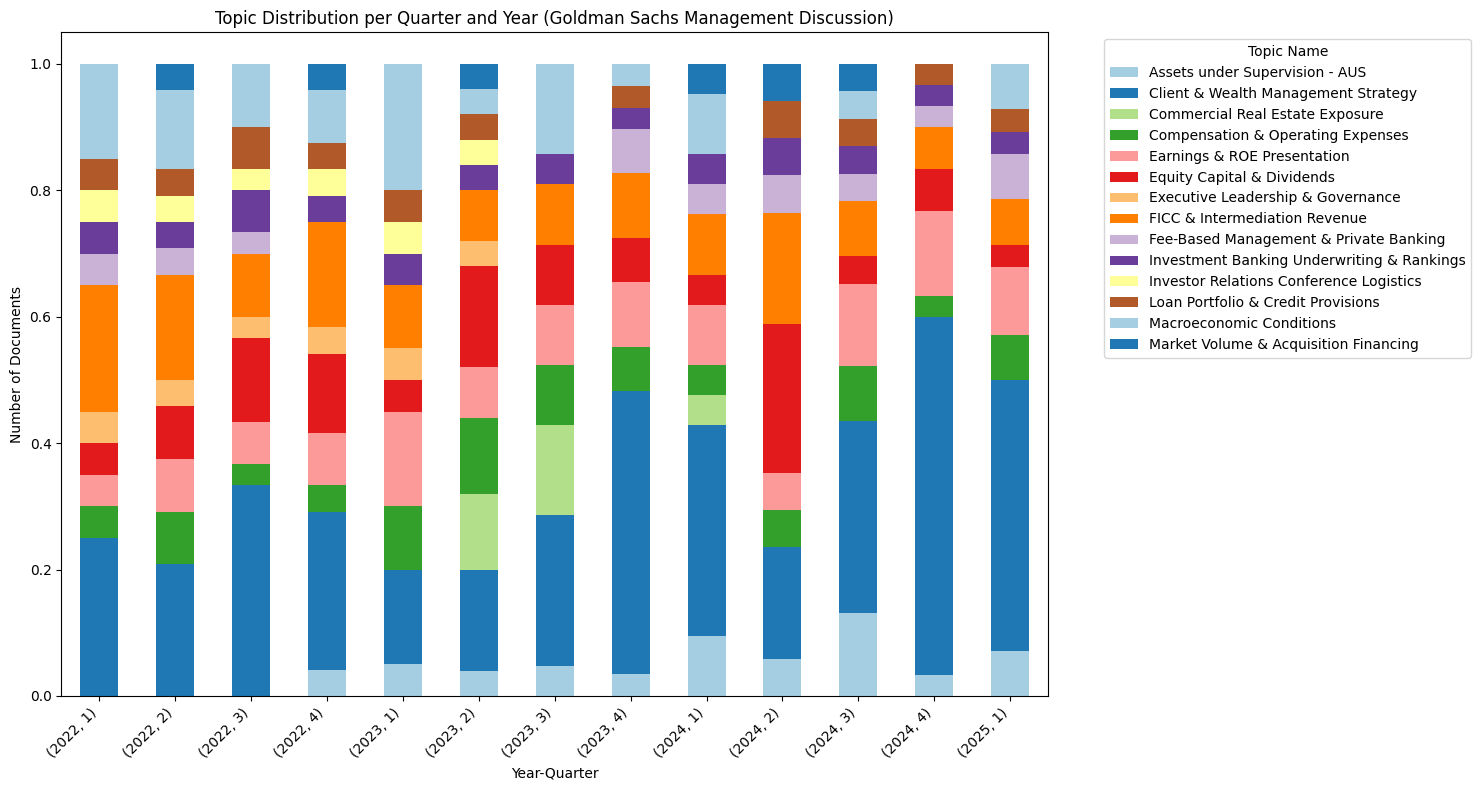

In [65]:
# prompt: processed_gs_discussion_df plot per quarter and year column the amount of value counts of topic name

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'topic_name' and time columns exist
if 'topic_name' not in processed_gs_discussion_df.columns:
    print("Error: 'topic_name' column not found in processed_gs_discussion_df.")
    # You might want to add a step here to assign topic names based on topic_id if needed
elif 'year' not in processed_gs_discussion_df.columns or 'quarter' not in processed_gs_discussion_df.columns:
     print("Error: 'year' or 'quarter' column not found in processed_gs_discussion_df.")
else:
    # Calculate value counts per quarter and year for topic names
    topic_counts = processed_gs_discussion_df.loc[~processed_gs_discussion_df['topic_id'].isin(gs_topics_to_exclude)].groupby(['year', 'quarter'])['topic_name'].value_counts().unstack(fill_value=0)

    topic_proportions = topic_counts.div(topic_counts.sum(axis=1), axis=0)

    num_topics = len(topic_proportions.columns)
    # colors = sns.color_palette(palette="RdBu", n_colors=num_topics) # Using 'viridis' for a professional look

    colors = sns.color_palette("Paired", n_colors=num_topics)
    # Plotting
    plt.figure(figsize=(15, 8))
    topic_proportions.plot(kind='bar', stacked=True, figsize=(15, 8), color=colors)

    plt.title('Topic Distribution per Quarter and Year (Goldman Sachs Management Discussion)')
    plt.xlabel('Year-Quarter')
    plt.ylabel('Number of Documents')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Topic Name', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [43]:
bertopic_gs_discussion_best_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,103,-1_portfolio_revenue_sale_platform,"[portfolio, revenue, sale, platform, investmen...","[equity investment produce net revenue $ , dri..."
1,0,97,0_client_management_franchise_business,"[client, management, franchise, business, lead...",[include number equity franchise ficc franchis...
2,1,35,1_revenue_ficc_intermediation_ﬁnance,"[revenue, ficc, intermediation, ﬁnance, ﬁnance...","[ficc net revenue $ . , % . intermediation , s..."
3,2,30,2_ep_david let_roe_ep roe,"[ep, david let, roe, ep roe, result page, let ...","[, david . . let result page presentation . ..."
4,3,28,3_common stock_dividend_stock_common,"[common stock, dividend, stock, common, requir...",[cet1 ratio .% end ﬁrst standardized approach ...
5,4,25,4_inﬂation_economy_interest rate_see,"[inﬂation, economy, interest rate, see, geopol...","[russia invade ukraine , inﬂation rise globe ,..."
6,5,21,5_compensation_expense_non compensation_compen...,"[compensation, expense, non compensation, comp...","[total quarterly operating expense $ . , % . d..."
7,6,14,6_inﬂow_alternative_aus total_alternative aus,"[inﬂow, alternative, aus total, alternative au...",[w e see $ liquidity inﬂow $ long term net i...
8,7,14,7_underwriting_number league_league table_league,"[underwriting, number league, league table, le...","[4q , ib fee fall % drive signiﬁcant decline e..."
9,8,12,8_portfolio_nii_pcl_portfolio end,"[portfolio, nii, pcl, portfolio end, total loa...","[page , ﬁrm wide nii $ . 4q % relative 3q , re..."


In [33]:

bertopic_gs_discussion_best_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,103,-1_portfolio_revenue_sale_platform,"[portfolio, revenue, sale, platform, investmen...","[equity investment produce net revenue $ , dri..."
1,0,97,0_client_management_franchise_business,"[client, management, franchise, business, lead...",[include number equity franchise ficc franchis...
2,1,35,1_revenue_ficc_intermediation_ﬁnance,"[revenue, ficc, intermediation, ﬁnance, ﬁnance...","[ficc net revenue $ . , % . intermediation , s..."
3,2,30,2_ep_david let_roe_ep roe,"[ep, david let, roe, ep roe, result page, let ...","[, david . . let result page presentation . ..."
4,3,28,3_common stock_dividend_stock_common,"[common stock, dividend, stock, common, requir...",[cet1 ratio .% end ﬁrst standardized approach ...
5,4,25,4_inﬂation_economy_interest rate_see,"[inﬂation, economy, interest rate, see, geopol...","[russia invade ukraine , inﬂation rise globe ,..."
6,5,21,5_compensation_expense_non compensation_compen...,"[compensation, expense, non compensation, comp...","[total quarterly operating expense $ . , % . d..."
7,6,14,6_inﬂow_alternative_aus total_alternative aus,"[inﬂow, alternative, aus total, alternative au...",[w e see $ liquidity inﬂow $ long term net i...
8,7,14,7_underwriting_number league_league table_league,"[underwriting, number league, league table, le...","[4q , ib fee fall % drive signiﬁcant decline e..."
9,8,12,8_portfolio_nii_pcl_portfolio end,"[portfolio, nii, pcl, portfolio end, total loa...","[page , ﬁrm wide nii $ . 4q % relative 3q , re..."


### GS QnA

# Topic Modelling - Post Finetune Trend Analysis

In [20]:
bertopic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,103,-1_portfolio_revenue_sale_platform,"[portfolio, revenue, sale, platform, investmen...","[equity investment produce net revenue $ , dri..."
1,0,97,0_client_management_franchise_business,"[client, management, franchise, business, lead...",[include number equity franchise ficc franchis...
2,1,35,1_revenue_ficc_intermediation_ﬁnance,"[revenue, ficc, intermediation, ﬁnance, ﬁnance...","[ficc net revenue $ . , % . intermediation , s..."
3,2,30,2_ep_david let_roe_ep roe,"[ep, david let, roe, ep roe, result page, let ...","[, david . . let result page presentation . ..."
4,3,28,3_common stock_dividend_stock_common,"[common stock, dividend, stock, common, requir...",[cet1 ratio .% end ﬁrst standardized approach ...
5,4,25,4_inﬂation_economy_interest rate_see,"[inﬂation, economy, interest rate, see, geopol...","[russia invade ukraine , inﬂation rise globe ,..."
6,5,21,5_compensation_expense_non compensation_compen...,"[compensation, expense, non compensation, comp...","[total quarterly operating expense $ . , % . d..."
7,6,14,6_inﬂow_alternative_aus total_alternative aus,"[inﬂow, alternative, aus total, alternative au...",[w e see $ liquidity inﬂow $ long term net i...
8,7,14,7_underwriting_number league_league table_league,"[underwriting, number league, league table, le...","[4q , ib fee fall % drive signiﬁcant decline e..."
9,8,12,8_portfolio_nii_pcl_portfolio end,"[portfolio, nii, pcl, portfolio end, total loa...","[page , ﬁrm wide nii $ . 4q % relative 3q , re..."


# Save Data Example

In [21]:

# import itertools
# output_dir = "data/temp/leslie_topic_modelling_fine_tuning/bert/jp/management_discussions/"
# os.makedirs(output_dir, exist_ok=True)

# AUTHENTICATED_REPO_URL = REPO_URL.replace("https://", f"https://{GITHUB_USERNAME}:{GITHUB_TOKEN}@")
# no_top_words = 10

# target_stopwords = nlp.stopwords
# target_df = processed_jp_discussion_df

# # Define parameter grids for grid-like search
# param_grid = {
#     'umap_n_neighbors': [15, 30], # Common values: 5-50
#     'umap_n_components': [5, 10], # Common values: 2-15
#     'hdbscan_min_cluster_size': [5, 10], # Common values: 5-50+ depending on dataset size
#     'vectorizer_min_df': [1, 5], # Common values: 1-10 or 0.01-0.05 (percentage)
#     'vectorizer_ngram_range': [(1, 1), (1, 2)] # (1,1) for unigrams, (1,2) for unigrams and bigrams
# }

# # Generate all combinations of parameters
# keys = param_grid.keys()
# combinations = itertools.product(*(param_grid[key] for key in keys))

# results = []

# for i, combo in enumerate(combinations):
#     params = dict(zip(keys, combo))

#     # Construct filename
#     filename_parts = []
#     for k, v in params.items():
#         if isinstance(v, tuple): # Handle tuples like ngram_range
#             filename_parts.append(f"{k}_{'_'.join(map(str, v))}")
#         else:
#             filename_parts.append(f"{k}_{v}")

#     output_filename_base = "_".join(filename_parts)
#     output_filename_bertopic = f"{output_dir}/bertopic_topics_{output_filename_base}.txt"
#     model_save_path = f"{output_dir}/bertopic_model_{output_filename_base}.joblib"

#     print(f"\n--- Running experiment {i+1} with parameters: {params} ---")

#     try:
#         # Initialize pipeline with current parameters
#         bertopic_pipeline_instance = TopicModelingPipeline(
#             embedding_model='all-MiniLM-L6-v2', # Keep embedding model constant for this grid search
#             model_type='bertopic',
#             nr_topics="auto", # Let HDBSCAN determine topics first, then prune if needed
#             calculate_probabilities=False, # Set to False for faster runs if probabilities aren't immediately needed for tuning
#             umap_args={'n_neighbors': params['umap_n_neighbors'], 'n_components': params['umap_n_components'], 'random_state': 42},
#             hdbscan_args={'min_cluster_size': params['hdbscan_min_cluster_size'], 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True},
#             vectorizer_args={'min_df': params['vectorizer_min_df'], 'ngram_range': params['vectorizer_ngram_range']},
#             stop_words=target_stopwords,
#             abbreviations=abbreviations
#         )

#         bertopic_pipeline_instance.fit(target_df['content'])
#         bertopic_model = bertopic_pipeline_instance.get_topic_model()

#         # Save topic info to file
#         with open(output_filename_bertopic, 'w', encoding='utf-8') as f:
#             f.write(f"--- BERTopic Model - Parameters: {params} ---\n\n")
#             f.write("Interpreting Topics:\n")
#             display_topics(bertopic_model, no_top_words=no_top_words, file=f)
#         print(f"BERTopic Topics saved to {output_filename_bertopic}")

#         !git config user.email "{GITHUB_EMAIL}"
#         !git config user.name "{GITHUB_USERNAME}"
#         !git remote set-url origin {AUTHENTICATED_REPO_URL}

#         # Add the file to staging
#         !git add {output_filename_bertopic}
#         print(f"Added '{output_filename_bertopic}' to staging.")

#         # Commit the changes
#         commit_message = f"Add new data file: {output_filename_bertopic}"
#         !git commit -m "{commit_message}"
#         print(f"Committed changes with message: '{commit_message}'")
#         print(f"Attempted commit with message: '{commit_message}'")

#         # Add this line to debug:
#         print(f"Value of REPO_BRANCH before push: {REPO_BRANCH}")

#         print("Pushing changes to GitHub. Please enter your GitHub username and Personal Access Token when prompted.")
#         !git push --set-upstream origin {REPO_BRANCH} --force

#         results.append({
#             'params': params,
#             'output_file': output_filename_bertopic,
#             'num_topics': len(bertopic_model.get_topic_info()) - 1 # Exclude -1 topic
#             # Add more metrics here if you implement them (e.g., coherence scores)
#         })

#     except Exception as e:
#         print(f"Error running experiment with parameters {params}: {e}")
#         results.append({'params': params, 'error': str(e)})

# print("\n--- Grid Search Complete ---")
# print("Summary of Runs:")
# for res in results:
#     if 'error' in res:
#         print(f"  Parameters: {res['params']} -> ERROR: {res['error']}")
#     else:
#         print(f"  Parameters: {res['params']} -> Topics: {res['num_topics']}, Output: {res['output_file']}")
